In [1]:
from PIL import Image
import torch
import torchvision.transforms as T
import torch.nn as nn
import os
import numpy as np
from matplotlib.pyplot import imread,imshow
from torchvision.transforms import Compose,CenterCrop,ToTensor
from torch.utils.data import DataLoader,Dataset

In [2]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
torch.cuda.device_count(),torch.cuda.is_available()

(1, True)

In [4]:
from google.colab.files import upload
upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rgiist","key":"78e42e8652505373d8e5b08660957da8"}'}

In [5]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download abhikjha/utk-face-cropped

 93% 217M/232M [00:01<00:00, 143MB/s]
100% 232M/232M [00:01<00:00, 137MB/s]


In [ ]:
!unzip 'utk-face-cropped.zip' -d /dataset

In [8]:
os.chdir("/dataset/utkcropped")
for i,files in enumerate(os.listdir()):
    os.rename(files,str(i)+'.jpg')

In [9]:
Images_train=os.listdir('/dataset/utkcropped')[:-50]
Images_test=os.listdir('/dataset/utkcropped')[-50:]

In [10]:
# def plot(x):
#     imshow(x/255)

encoder = nn.Sequential(
    nn.Conv2d(3,32,kernel_size=3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=None),

    nn.Conv2d(32,64,kernel_size=3,padding='same'),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=None),

    nn.Conv2d(64,128,kernel_size=3,padding='same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=None),

    nn.Conv2d(128,256,kernel_size=3,padding='same'),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=None)

)

decoder=nn.Sequential(
    nn.ConvTranspose2d(256,128,kernel_size=3,stride=2),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.ConvTranspose2d(128,64,kernel_size=3,stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # nn.ConvTranspose2d(64,32,kernel_size=3,stride=2),
    # nn.BatchNorm2d(32),
    # nn.ReLU(),

    nn.ConvTranspose2d(64,3,kernel_size=3,stride=2),
    nn.ReLU()
)

AutoEncoder=nn.Sequential(
#Encoder
    nn.Conv2d(3,32,kernel_size=3,padding='same'),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=None),

    nn.Conv2d(32,64,kernel_size=3,padding='same'),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=None),

    nn.Conv2d(64,128,kernel_size=3,padding='same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=None),

    nn.Conv2d(128,256,kernel_size=3,padding='same'),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=None),

    nn.Conv2d(256,512,kernel_size=3,padding='same'),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=None),

# Decoder
    nn.ConvTranspose2d(512,256,kernel_size=3,stride=2),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    
    nn.ConvTranspose2d(256,128,kernel_size=3,stride=2),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.ConvTranspose2d(128,64,kernel_size=3,stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # nn.ConvTranspose2d(64,32,kernel_size=3,stride=2),
    # nn.BatchNorm2d(32),
    # nn.ReLU(),

    nn.ConvTranspose2d(64,3,kernel_size=3,stride=2),
    nn.ReLU()   
)

encoder=encoder.to(device)
decoder=decoder.to(device)
# AutoEncoder=AutoEncoder.to(device)

In [ ]:
data=np.array(data,dtype=np.float32)
decoder(encoder(torch.from_numpy(data).view(1,-1,3,400,400)[0].to(device))).shape

In [ ]:
idx1,idx2 = np.random.randint(0,199),np.random.randint(0,199)
data=np.random.randint(low=0,high=255,size=(1,400,400,3))
output=np.random.randint(low=0,high=255,size=(1,199,199,3))
data[0][idx1:idx1+200,idx2:idx2+200,:]=np.array(Image.open(Images_train[0]))
output[0]=np.array(Image.open(Images_train[0]))[:-1,:-1,:]
# imshow(data.reshape(400,400,3))
output.shape

In [11]:
lr=0.01
enc_opt=torch.optim.Adam(encoder.parameters(),lr=lr)
dec_opt=torch.optim.Adam(decoder.parameters(),lr=lr)
for epoch in range(8):
    for j,images in enumerate(Images_train):
        if images != '23438.jpg':
            idx1,idx2 = np.random.randint(0,199),np.random.randint(0,199)
            data=np.random.randint(low=0,high=255,size=(1,400,400,3))
            output=np.random.randint(low=0,high=255,size=(1,199,199,3))
            # for i in range(len(images)):
            data[0][idx1:idx1+200,idx2:idx2+200,:]=np.array(Image.open(images))
            output[0]=np.array(Image.open(images))[:-1,:-1,:]
            data=np.array(data,dtype=np.float32)
            output= np.array(output,dtype=np.float32)

            data,output = torch.from_numpy(data),torch.from_numpy(output)
            data_tensor=data.view(1,-1,3,400,400)
            output_tensor=output.view(1,-1,3,199,199)
            data_tensor,output_tensor=data_tensor.to(device),output_tensor.to(device)
            # with torch.cuda.device(0):
            # for i in range(len(images)):
            enc_opt.zero_grad()
            dec_opt.zero_grad()
            out=decoder(encoder(data_tensor[0]))
            cropped=out.flatten()
            target=output_tensor[0].flatten()
            loss=torch.linalg.vector_norm((cropped-target),ord=2)
            loss.backward()
            enc_opt.step()
            dec_opt.step()

        # data = data.type(torch.LongTensor)

In [ ]:
path='/content/drive/MyDrive/IMPORTANT DOCS/ae.pickle'
torch.save(AutoEncoder.state_dict(),path)

In [23]:
path1='/content/drive/MyDrive/IMPORTANT DOCS/enc.pickle'
torch.save(encoder.state_dict(),path1)

path2='/content/drive/MyDrive/IMPORTANT DOCS/dec.pickle'
torch.save(decoder.state_dict(),path2)

In [51]:
from google.colab.files import upload
img=upload()

Saving ryandarr_resized.jpg to ryandarr_resized (1).jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


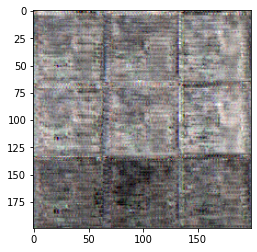

In [52]:
out = decoder(encoder(torch.from_numpy(np.array(Image.open('ryandarr_resized.jpg'),dtype=np.float32)).view(1,3,400,400).to(device)))
imshow(out.reshape(199,199,3).cpu().detach().numpy()/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


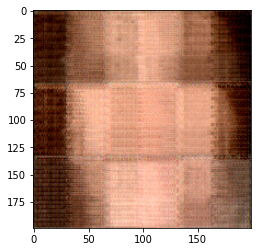

In [41]:
img=np.array(Image.open(Images_test[9]))
idx1,idx2 = np.random.randint(0,199),np.random.randint(0,199)
data=np.random.randint(low=0,high=255,size=(1,400,400,3))
data[0][idx1:idx1+200,idx2:idx2+200,:]=img
data = np.array(data,dtype=np.float32)
out_img=decoder(encoder(torch.from_numpy(data[0]).view(1,3,400,400).to(device)))
imshow(out_img.reshape(199,199,3).cpu().detach().numpy()/255)

tensor(392.6881, device='cuda:0', grad_fn=<MaxBackward1>)